# GLAD Alert widgets

In [1]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [2]:
from datetime import date
from datetime import timedelta
import datetime
import math

valid_countries = ['Brazil', 'Colombia', 'Ecuador', 'French Guiana', 'Guyana', 'Peru', 'Suriname', 'Venezuela',
             'Burundi', 'Cameroon', 'Central African Republic', 'Democratic Republic of the Congo',
              'Equatorial Guinea', 'Gabon', 'Republic of the Congo', 'Rwanda', 'Uganda',
             'Brunei', 'Indonesia', 'Malaysia', 'Papua New Guinea', 'Timor Leste']


### Daily/Weekly/Monthly Alerts 

We should get Alerts over several time periods are a range of different temporal resolutions.
We need to calculate:

1. Last date in the returned data (and convert it to a real date)
1. depending on a variable time selection (e.g. past week, past 3 weeks, past 3 months, past 6 months) select back in time (including a leading period to use as a smooth)
1. select the same time window for all previous years, and composite/stack the time together
1. create a boxcar smooth mean to use as the center of the certainty range
1. calculate a single standard deviation for the whole period (which should be the average standard deviation of all the individual time-point standard deviations)
1. test plot, floor the sigma range at 0

# Functions

In [10]:
def create_df(alert_data):
    
    tmp_list = []
    for row in alert_data:
        tmp_list.append([row.get('year', None),
                         row.get('month', None),
                         row.get('week', None),
                         row.get('count', None),
                         row.get('julian_day', None)])
    df = pd.DataFrame(tmp_list, columns=['year','month','week','count','julian_day'])
    
    return df

In [11]:
def plot_df(df):
    
     return df.sort_values(['year','month', 'week','julian_day'])['count'].plot()

In [12]:
def get_start_date(data):
        
    last_index = len(data)-1

    julian_day = data[last_index].get('julian_day', None)
    current_week = data[last_index].get('week', None)
    current_year = data[last_index].get('year', None)

#     if julian_day:
#         date = datetime.datetime.strptime(current_year + julian_day, '%Y%j').date()
#         return date.strftime('%Y-%m-%d')
    

        
    return {'year': current_year, 'week': current_week, 'julian_day': julian_day}

In [47]:
def search_returned(year, week, day, response):
    for row in response:
        tmp_week = row.get('week', None)
        tmp_day = row.get('julian_day', None)
        tmp_year = row.get('year', None)
        tmp_count = row.get('count', None)
        if (tmp_week == week) and (tmp_year == year) and (tmp_day == day):
            return tmp_count
    return 0



In [57]:
def fill_zeroes(response, aggregate='week'):

    data = []
    end_y = get_start_date(response).get('year')

    for year in range(2015, end_y+1):
        if year == 2015:
            end_w = 53
            end_d = 365
        elif year == 2016:
            end_w = 53
            end_d = 366
        elif year == 2017:
            end_w = 52
            end_d = 365
            
        if aggregate == 'week':
            
            for week in range(1, end_w+1):
                tmp = search_returned(year=year, week=week, day=None, response=response)
                data.append({'count': tmp, 'week': week, 'year': year})
        
        elif aggregate == 'day':
            
            for day in range(1, end_d+1):
                tmp = search_returned(year=year, week=None, day=day, response=response)
                data.append({'count': tmp, 'day': day, 'year': year})


    return data

In [72]:
def glads_queries(iso, adm1=None, adm2=None, period='week'):

    if period in ['day','week','month']:
        
        if adm2:
            print(f'Requesting adm2 alerts aggregated by {period}')
            url = f'https://production-api.globalforestwatch.org/glad-alerts/admin/{iso}/{adm1}/{adm2}?aggregate_values=true&aggregate_by={period}'
        elif adm1:
            print(f'Requesting adm1 alerts aggregated by {period}')
            url = f'https://production-api.globalforestwatch.org/glad-alerts/admin/{iso}/{adm1}?aggregate_values=true&aggregate_by={period}'
        elif iso:
            print(f'Requesting adm0 alerts aggregated by {period}')
            url = f'https://production-api.globalforestwatch.org/glad-alerts/admin/{iso}?aggregate_values=true&aggregate_by={period}'
    
        r = requests.get(url)
        print(r.url)

        return r.json().get('data',None).get('attributes', None).get('value', None)
    
    else:
        print("Unable to handle request")

In [44]:
def get_glads_data(iso=iso, adm1=adm1, adm2=adm2, aggregate='week'):
    """Aggregate determines the binning of data. Can be either 'day',
    'week', or 'month'..."""
    
    if iso_to_countries[iso] in valid_countries:
        data = glads_queries(iso=iso, adm1=adm1, adm2=adm2, period=aggregate)
        data = fill_zeroes(data, aggregate)

        return data
    
    else:
        print('Error: no glads data in this region')
        return None


In [80]:
def get_glads_stats(data):
    
    window = 12
    counts = []

    for t in range(0, len(data)):
        counts.append(data[t].get('count'))

    means = []
    sigmas = []

    for i in range(0, 6):
            means.append(np.mean([counts[53-5+i],counts[106-5+i]]))

    for i in range(0, 52):
            means.append(np.mean([counts[i],counts[i+53],counts[i+106]]))
            sigmas.append(np.std([counts[i],counts[i+53],counts[i+106]]))

    for i in range(0, 6):
            means.append(np.mean([counts[i+53],counts[i+106]]))
        
    ave_std = np.mean(sigmas)
    
    d = {'mean': means}
    df = pd.DataFrame(data=d)
    
    N = window
    x = df['mean']
    means = np.convolve(x, np.ones((N,))/N, mode='valid').tolist()
    
    return {'mean_data': means, 'sigma': ave_std}



In [16]:
def get_glads_plot(means, std, data):
    
    x_val = []
    plt_data = []
    for i in range(0, len(means)):
        x_val.append(i)
        
        #data is the dataset we want to use to
        plt_data.append(data[len(data)-len(means)+i].get('count'))   

    lthick=1.0

    plt.plot(plt_data, 'r-', color='magenta')  # week in question=RED
    plt.plot(means, 'k-',lw=lthick)  # mean=BLACK
    plt.plot(means+std, 'k--',lw=lthick)  # mean=BLACK
    plt.plot(means-std, 'k--',lw=lthick)  # mean=BLACK
    plt.plot(means+2*std, 'k--',lw=lthick)  # mean=BLACK
    plt.plot(means-2*std, 'k--',lw=lthick)  # mean=BLACK

    plt.fill_between(x_val, means-2*std, means-std, color='grey', alpha=0.05)
    plt.fill_between(x_val, means+std, means+2*std, color='grey', alpha=0.05)
    plt.fill_between(x_val, means-std, means+std, color='grey', alpha=0.25)

    ax = plt.gca()

    ax.set_ylim([0,1.05*max(max(plt_data), max(means)+2*std)])
    ax.set_xlabel('weeks')
    ax.set_ylabel('alert count')

    plt.show()    

# Window vs Data

The above mean +/- standard deviation lines will be requestd and calculated as standard by the front end i.e using data from all previous years, binned by week, and smoothed with a 3 month convolution-window to give year-long statistical bounds.

In the above: 

- black = mean,
- dark grey = 1 sigma band,
- light grey = 2 sigma band

The current years data will then be overplotted (magenta in the above graph) on a 'window' of the above statistical bands.

The user can then view a 'window' of size (with data overlayed):

- the last week (daily data)
- last month (daily data)
- last 3 months (weekly data)
- last 6 months (weekly data)
- last year (weekly)

### Process

1. Get stats for whole year, calculate mean & std values
2. Get data for window


In [66]:
iso = 'BRA'
adm1 = None
adm2 = None

In [81]:
%%time

data = get_glads_data(iso=iso, adm1=adm1, adm2=adm2, aggregate='week')

Requesting adm0 alerts aggregated by week
https://production-api.globalforestwatch.org/glad-alerts/admin/BRA?aggregate_values=true&aggregate_by=week
CPU times: user 14.3 ms, sys: 12.7 ms, total: 27 ms
Wall time: 463 ms


In [82]:
data[0:5]

[{'count': 188135, 'week': 1, 'year': 2015},
 {'count': 223100, 'week': 2, 'year': 2015},
 {'count': 130833, 'week': 3, 'year': 2015},
 {'count': 160172, 'week': 4, 'year': 2015},
 {'count': 483794, 'week': 5, 'year': 2015}]

In [83]:
stats = get_glads_stats(data)
means = stats.get('mean_data')
std = stats.get('sigma')

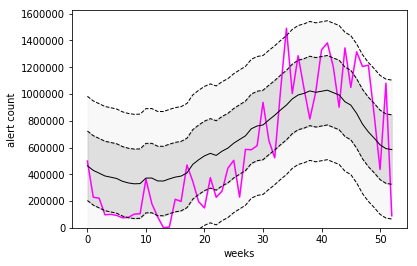

In [84]:
get_glads_plot(means, std, data)

# Dynamic Sentences


In [ ]:
print(f"There were {historic_data[w].get('count')} GLADS alerts reported ", end="")
print(f"in the week starting {historic_data[week].get('start_date')}, ", end="")
print(f"compared to ", end="")
n = 1

while week-(52*n) > 0:
    if n > 1:
        print(f", ", end="")
    if historic_data[week-(52*n)].get('start_date')[0:4] == '2015':
        print(f"and ", end="")
        
    if historic_data[week-(52*n)].get('count') > historic_data[week-(52*(n-1))].get('count'):
        arrow = '↑'
    elif historic_data[week-(52*n)].get('count') < historic_data[week-(52*(n-1))].get('count'):
        arrow = '↓'
    else:
        arrow = '-'
        
    print(f"{historic_data[week-(52*n)].get('count')}({arrow}) ", end="")
    print(f"in {historic_data[week-(52*n)].get('start_date')[0:4]}", end="")
    n += 1
    
print(f".", end="")
    
### Note: (↑) indicates that current year is an increse over that year, (↓) means a decrease 

In [ ]:
print(f"There were {historic_data[w].get('count')} GLADS alerts reported ", end="")
print(f"in the week starting {historic_data[week].get('start_date')}, ", end="")

if historic_data[week].get('count') > historic_data[week-52].get('count') and historic_data[week-52].get('count'):
    print(f"an increase of {historic_data[week].get('count') - historic_data[week-52].get('count')} ", end="")
else:
    print(f"an decrease of {historic_data[week].get('count') - historic_data[week-52].get('count')} ", end="")
    
print(f"over the corresponding week in {historic_data[week-52].get('start_date')[0:4]}. ", end="")
    
    

# Test

We need to precalc weekly stats over the entirety of the temporal data.

In [3]:
test_i = '2015-01-01'

In [4]:
date_1 = datetime.datetime.strptime(test_i, "%Y-%m-%d")
date_1

datetime.datetime(2015, 1, 1, 0, 0)

In [5]:
date_2 = date_1 + timedelta(days=7) 
date_2

datetime.datetime(2015, 1, 8, 0, 0)

In [6]:
test_f = datetime.datetime.isoformat(date_2)[:10]
test_f

'2015-01-08'

In [7]:
test_data = get_glads(start_date=test_i, end_date=test_f, iso=iso, adm1=adm1, threshold=threshold)

NameError: name 'get_glads' is not defined

In [ ]:
test_data